1. IMPORTING LIBRARIES

In [2]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import *
from sklearn.metrics import *
from tensorflow.keras import *
from keras.models import load_model
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

2024-02-29 09:53:25.043327: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 09:53:25.076989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 09:53:25.077021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 09:53:25.078025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 09:53:25.083386: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 09:53:25.083790: I tensorflow/core/platform/cpu_feature_guard.cc:1

2. LOADING THE DATA

In [6]:
# Loading Training Data
training_dir = '../cancer-code/Dataset/Train_Images/'
training_paths = []
train_labels = []

for label in os.listdir(training_dir):
    label_dir = os.path.join(training_dir, label)
    if os.path.isdir(label_dir):  # Check if it's a directory
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                training_paths.append(file_path)
                train_labels.append(label)

random.shuffle(training_paths)
random.shuffle(train_labels)

# show an example of the list
print(training_paths[0])

../cancer-code/Dataset/Train_Images/LGSC/15957.png


In [7]:
len(training_paths)

33783

In [8]:
# Loading Testing/Validation Data
test_dir = '../cancer-code/Dataset/Test_Images/'
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):  # Check if it's a directory
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                test_paths.append(file_path)
                test_labels.append(label)

random.shuffle(test_paths)
random.shuffle(test_labels)

# show an example of the list
print(test_paths[0])

../cancer-code/Dataset/Test_Images/CC/31029.png


In [9]:
len(test_paths)

3082

In [11]:
labels = [label for label in os.listdir(training_dir) if not label.startswith('.')]

labels

['EC', 'CC', 'LGSC', 'MC', 'HGSC']

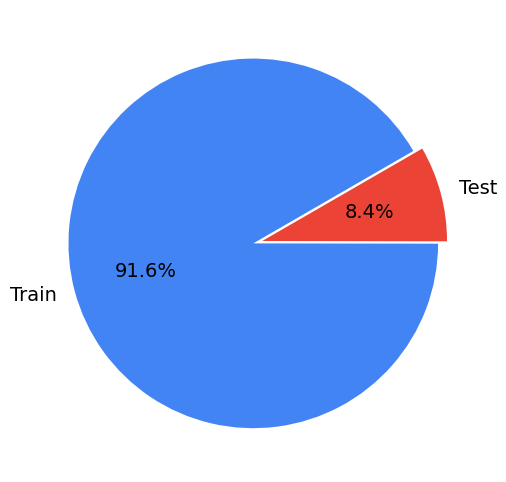

In [12]:
# Ratio of Training Data to Testing Data
plt.figure(figsize=(14,6))
colors = ['#4284f4', '#eb4335']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

3. DATA AUGMENTATION

In [13]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(256,256))
        image = image.convert('RGB')
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

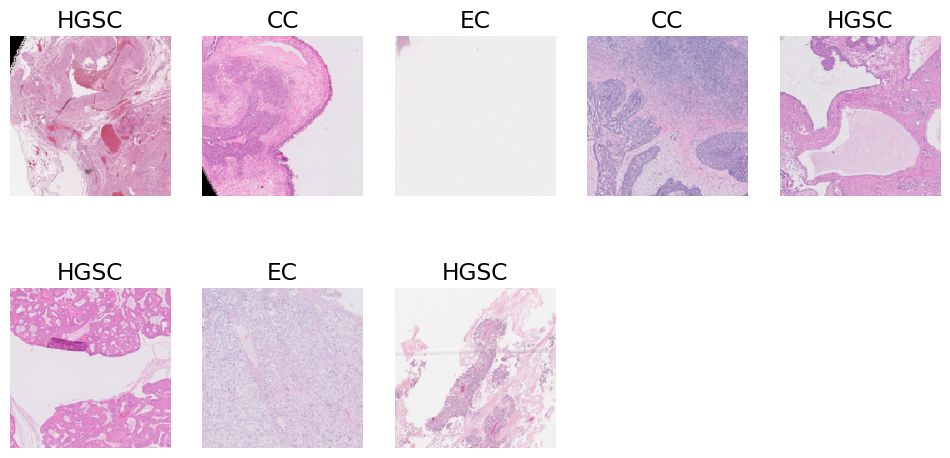

In [14]:
i = random.randint(0,len(training_paths))
images = open_images(training_paths[50:59])
xlabels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 5, x)
    plt.axis('off')
    plt.title(xlabels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 10})
plt.show()

4. DATA GENERATOR

In [23]:
# Expand the size of a training set by creating modified data from existing one
def data_gen(data_paths, batch_size=10):
    '''
    Given the image paths, it yields the images with the respective labels, as a batch
    '''
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        labels = get_labels(paths)
        yield images,np.array(labels)

5. BUILDING THE ResNet152V2 MODEL

In [24]:
# Loading the Pre-Trained Model (ResNet152V2)

base_model = ResNet152V2(input_shape = (256,256,3), 
                                                include_top = False, 
                                                weights = 'imagenet' )
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [25]:
len (base_model.layers)

564

In [26]:
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
# Set the last ResNet152V2 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [27]:
model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax')) # num labels = 4

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_2 (Dropout)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 75109637 (286.52 MB)
Trainable params: 1

6. TRAINING THE MODEL

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='sparse_categorical_crossentropy', 
                                metrics=['sparse_categorical_accuracy'])

In [29]:
# Training the Model

batch_size=256

history = model.fit(data_gen(training_paths), 
epochs=20,
steps_per_epoch=int(len(training_paths)/batch_size), 
validation_data= data_gen(test_paths),
validation_steps=int(len(test_paths)/batch_size)
 )

Epoch 1/40
131/131 [==============================] - 174s 1s/step - loss: 1.7641 - sparse_categorical_accuracy: 0.3809 - val_loss: 1.4175 - val_sparse_categorical_accuracy: 0.4250
Epoch 2/40
131/131 [==============================] - 168s 1s/step - loss: 1.4174 - sparse_categorical_accuracy: 0.4305 - val_loss: 1.1872 - val_sparse_categorical_accuracy: 0.5417
Epoch 3/40
131/131 [==============================] - 169s 1s/step - loss: 1.3922 - sparse_categorical_accuracy: 0.4344 - val_loss: 1.2423 - val_sparse_categorical_accuracy: 0.4917
Epoch 4/40
131/131 [==============================] - 182s 1s/step - loss: 1.3802 - sparse_categorical_accuracy: 0.4550 - val_loss: 1.0959 - val_sparse_categorical_accuracy: 0.6167
Epoch 5/40
131/131 [==============================] - 181s 1s/step - loss: 1.3298 - sparse_categorical_accuracy: 0.4702 - val_loss: 1.2118 - val_sparse_categorical_accuracy: 0.5667
Epoch 6/40
131/131 [==============================] - 170s 1s/step - loss: 1.2818 - sparse_cate

7. EVALUATING THE MODEL

In [30]:
evaluation = model.evaluate(data_gen(test_paths))
print('Test Loss:', evaluation[0])
print('Test Accuracy:', evaluation[1])

309/309 [==============================] - 335s 1s/step - loss: 0.8499 - sparse_categorical_accuracy: 0.6645
Test Loss: 0.849861204624176
Test Accuracy: 0.6645035743713379


In [ ]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
label = test_paths[i].split('/')[-2]
# plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)

In [37]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


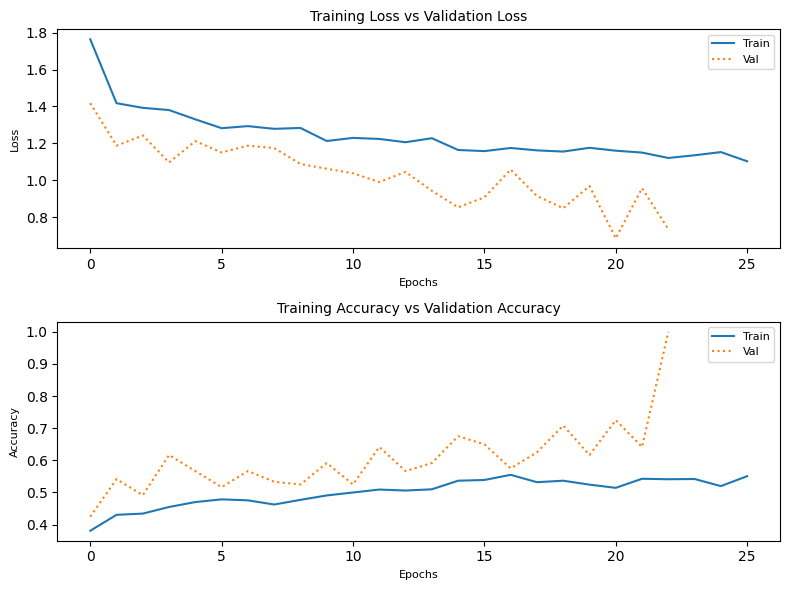

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Adjust the figure size as needed

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'], linestyle='dotted')
axs[0].set_title('Training Loss vs Validation Loss', fontsize=10)
axs[0].set_xlabel('Epochs', fontsize=8)
axs[0].set_ylabel('Loss', fontsize=8)
axs[0].legend(['Train', 'Val'], fontsize=8)

axs[1].plot(history.history['sparse_categorical_accuracy'])
axs[1].plot(history.history['val_sparse_categorical_accuracy'], linestyle='dotted')
axs[1].set_title('Training Accuracy vs Validation Accuracy', fontsize=10)
axs[1].set_xlabel('Epochs', fontsize=8)
axs[1].set_ylabel('Accuracy', fontsize=8)
axs[1].legend(['Train', 'Val'], fontsize=8)

plt.tight_layout()  
plt.show()


8. CLASSIFICATION REPORT AND CONFUSION MATRIX

In [34]:
# Classification Report
y_pred = model.predict(data_gen(test_paths))
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.array(get_labels(test_paths))

target_names = labels
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=target_names))

309/309 [==============================] - 323s 1s/step
Classification Report:
              precision    recall  f1-score   support

          EC       0.64      0.53      0.58       733
          CC       0.74      0.64      0.68       551
        LGSC       0.72      0.45      0.56       287
          MC       0.76      0.47      0.58       323
        HGSC       0.63      0.87      0.73      1188

    accuracy                           0.66      3082
   macro avg       0.70      0.59      0.63      3082
weighted avg       0.68      0.66      0.65      3082



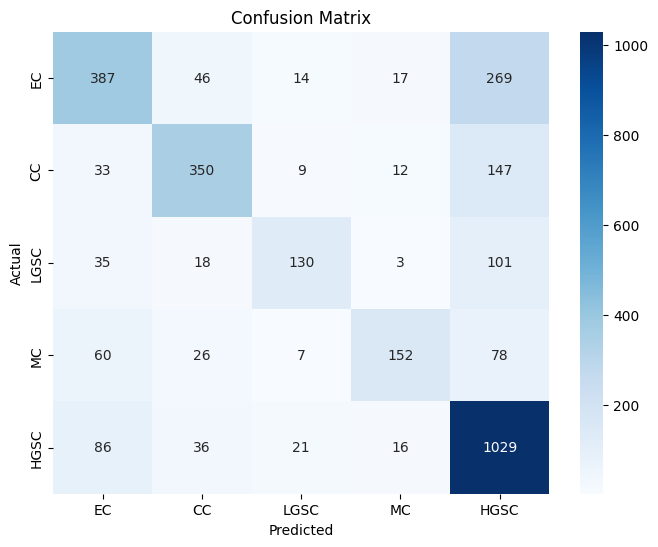

In [35]:
#Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

9. SAVING THE MODEL

In [39]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open('cancer.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpu_r3y65c/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_r3y65c/assets
2024-02-29 14:10:43.885848: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-29 14:10:43.885877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-29 14:10:43.886152: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpu_r3y65c
2024-02-29 14:10:43.962028: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-29 14:10:43.962093: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpu_r3y65c
2024-02-29 14:10:44.107313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-29 14:10:44.167846: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-29 14:10:45.855046: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio